# Descriptivo general. Cuestionario Complementario

In [1]:
import os
os.chdir('../../')
#os.chdir('./aprender_cife')

In [2]:
%matplotlib inline  
import pandas as pd
import matplotlib.pyplot as plt
from funciones.abrir_bases import cod_sec_2017
import numpy as np


df = pd.read_csv('./data/aprender2017-secundaria-12.csv', sep='\t', encoding='iso-8859-3', na_values=' ', dtype='object')

## Convertimos algunas variables a numéricas
l = ['ponder', 'lpondera', 'mpondera', 'TEL', 'TEM']
df[l] = df[l].apply(lambda x: x.str.replace(',', '.').astype('float64'))

## Agregamos una variable indicadora
df['indicator'] = 1

cod = cod_sec_2017()
cols = df.columns


Definimos algunas funciones para analizar los datos y graficar.

In [3]:
#%% Funciones
def categorizar_var(var, df=df.copy(), cod=cod):
    '''Categoriza la variable. Convierte el string en CategoricalDtype. Devuelve las categorías y un diccionario con las equivalencias'''
    df[var] = df[var].astype(str)
    
    def cambiar_cat(s):
        from pandas.api.types import CategoricalDtype
        c = CategoricalDtype(cod.loc[s.name, 'Códigos'], ordered=True)
        return s.astype(c)
    
    return df[var].apply(cambiar_cat)

def to_float(var, df=df):
    return df[var].str.replace(',', '.').astype('float64')

def from_to(str1, str2, cols=cols):
    import numpy as np
    return cols[np.where(cols == str1)[0][0]:np.where(cols == str2)[0][0]+1]

def val_lab(var, cod=cod):
    from pandas.api.types import CategoricalDtype
    ref = cod.loc[var,['Códigos', 'Etiqueta.1']].reset_index(drop=True)
    
    ## Construimos las categorías
    c = CategoricalDtype(ref['Códigos'], ordered=True)
    
    ## Convertimos Códigos a categoría
    ref['Códigos'] = ref['Códigos'].astype(c)
    
    return ref.set_index('Códigos')

def col_lab(var, cod=cod):
    return cod.loc[var,'Etiqueta'].unique()[0]

def tabla_pond(var, df=df, rel=True):
    '''Toma una lista de nombres de variables y devuelve una tabla de frecuencias.
    var: list of strings
    rel: True - False. Define si se calculan las frecuencias relativas o absolutas.
    '''
    
    tabla = df[var].apply(lambda x: df.groupby(x)['ponder'].sum())
    
    if rel:
        tabla = tabla / tabla.sum()
    
    return tabla

def tabla(var, df=df, rel=True):
    '''Toma una lista de nombres de variables y devuelve una tabla de frecuencias.
    var: list of strings
    rel: True - False. Define si se calculan las frecuencias relativas o absolutas.
    '''
    
    tabla = df[var].apply(lambda x: df.groupby(x)['indicator'].sum())
    
    if rel:
        tabla = tabla / tabla.sum()
    
    return tabla

def etiquetas(t):
    ''' Toma una tabla y busca las etiquetas para los códigos de columna y de valores.
    Devuelve una tupla con 2 DataFrames (colnames, valnames)
    '''
    import pandas as pd
    colnames = pd.Series(t.columns, index=t.columns).apply(col_lab)
    valnames = val_lab(t.columns[0])
    return colnames, valnames
#%%
l = from_to('ap1','ambito')
df[l] = categorizar_var(l)

In [4]:
#%% Funciones Gráficas
def barras(t, ax):
    t = t.sort_index(ascending=False)
    
    colnames, valnames = etiquetas(t)
    
    valnames = valnames.reindex(t.index)
    
    ## Construimos los colores
    valnames['color'] = valnames.index.map(lambda x: int(x) < 0).map({False:'steelblue', True:'grey'})   
    
    ## Graficamos
    t.iloc[:,0].plot(kind='barh',
                     width=0.8,
                     ax=ax,
                     legend=False,
                     color=valnames.color.values)
    
    ## Colocamos las etiquetas
    ax.set_yticklabels(valnames['Etiqueta.1'])
    ax.set(title=colnames[0],
      ylabel='',
      xlabel='Proporción de estudiantes',
      xlim=(0,1))
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    #plt.tight_layout()
    #plt.show()

def col_cat(t):
    '''Construye una paletta de colores para graficar las tablas.
    t: tabla
    
    # Values
    Devuelve un DataFrame con un color para cada fila.'''
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    
    colnames, valnames = etiquetas(t)
    
    ## Identificamos las categorías menores a cero
    i = pd.Series(valnames.index.map(lambda x: int(x) < 0), dtype='bool')
    
    ## Evaluamos la cantidad de categorías por color
    n_cat = (~i).sum()
    n_grey = i.sum()
    
    ## Seleccionamos los colores de las categorías color
    cat = cm.get_cmap('tab10', 10)
    
    color = pd.DataFrame(cat(range(n_cat)),index=t.index[~i])
    
    ## Seleccionamos los colores de las categorías gris
    gray = cm.get_cmap('Greys', 10)
    
    color = color.append(pd.DataFrame(gray([2,5,8]), index=t.index[i]))
    
    return color

def col_div(t):
    '''Construye una paleta divergente de colores para graficar las tablas.
    t: tabla
    
    # Values
    Devuelve un DataFrame con un color para cada fila.'''
    from matplotlib import cm
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    
    colnames, valnames = etiquetas(t)
    
    ## Identificamos las categorías menores a cero
    i = pd.Series(valnames.index.map(lambda x: int(x) < 0), dtype='bool')
    
    ## Evaluamos la cantidad de categorías por color
    n_cat = (~i).sum()
    n_grey = i.sum()
    
    ## Seleccionamos los colores de las categorías color
    cat = cm.get_cmap('RdBu', 30)
    
    color = pd.DataFrame(cat(np.linspace(3, 27, n_cat).astype(int)),index=t.index[~i])
    
    ## Seleccionamos los colores de las categorías gris
    gray = cm.get_cmap('Greys', 10)
    
    color = color.append(pd.DataFrame(gray([2,5,8]), index=t.index[i]))
    
    return color

def barras_apiladas(t, ax, parse_labels=True):
    import textwrap
    import re
    colnames, valnames = etiquetas(t)
    valnames = valnames.reindex(t.index)
    
    if parse_labels:    
        ## Utilizamos expresiones regulares para separar el título de las etiquetas
        exp = re.compile('(?P<title>.*[…?])(?P<label>.*)')
        colnames = colnames.str.extract(exp)
    else:
        colnames = pd.DataFrame(colnames, columns=['label'])
        colnames['title'] = ''
        
    # Agregamos breaklines para la visualización
    colnames['label'] = colnames['label'].apply(lambda x: textwrap.fill(x, width=30))
    
    t.T.plot(kind='barh',
             stacked=True,
             ax=ax,
             color=col_div(t).values)

    ## Colocamos las etiquetas
    ax.set_yticklabels(colnames.label)
    ax.set(title=colnames.title[0],
              ylabel='',
              xlabel='Proporción de estudiantes',
              xlim=(0,1))
    
    ax.legend(valnames['Etiqueta.1'])
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Put a legend below current axis
    ax.legend(valnames['Etiqueta.1'], loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=False, shadow=False, ncol=len(valnames['Etiqueta.1']))
    
    #plt.tight_layout()
    #plt.show()

## Total de casos

In [5]:
#df.info()

In [6]:
df.ponder.size

316015

In [7]:
## Total de nan para cuestionario complementario
df.ponder.isna().sum()

344

## Categorizamos las variables

In [8]:
l = from_to('ap1','ambito')
df[l] = categorizar_var(l)

## Graficamos

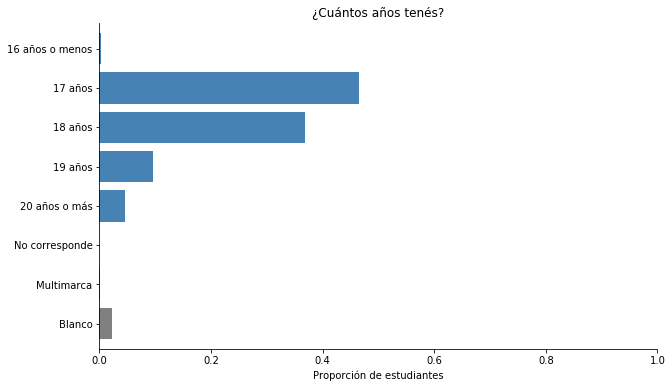

In [9]:
t = tabla_pond(['ap1'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax)  

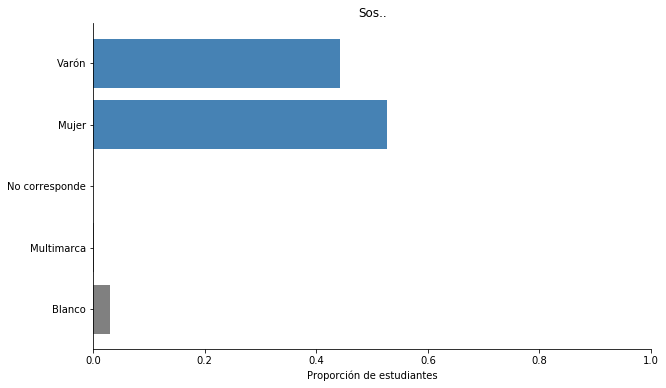

In [10]:
t = tabla_pond(['ap2'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

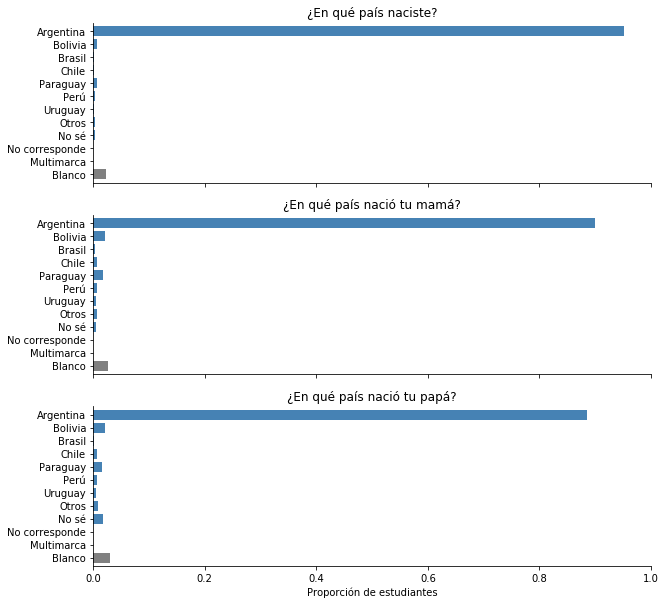

In [11]:
l = from_to('ap3a', 'ap3c')

fig, axs = plt.subplots(3,1, sharex=True, figsize=(10,10))

for i in range(len(l)):
    barras(tabla_pond([l[i]]), axs[i])


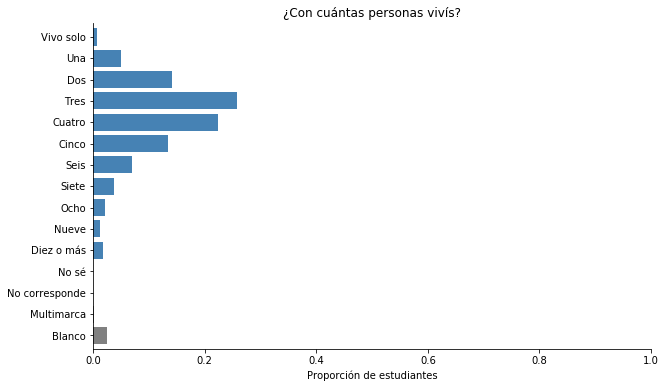

In [12]:
t = tabla_pond(['ap4'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

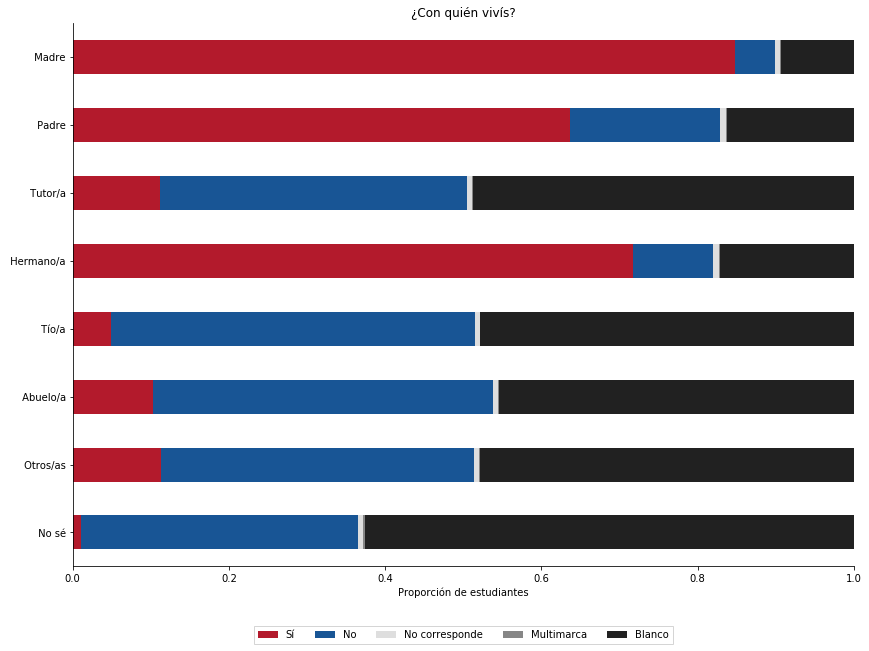

In [13]:
l = from_to('ap5a', 'ap5h')
l = l[::-1]
t=tabla_pond(l)
fig, ax = plt.subplots(figsize=(14,10))
barras_apiladas(t, ax)

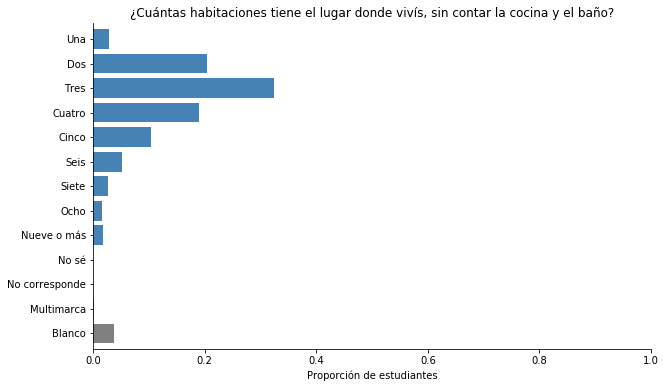

In [14]:
t = tabla_pond(['ap6'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

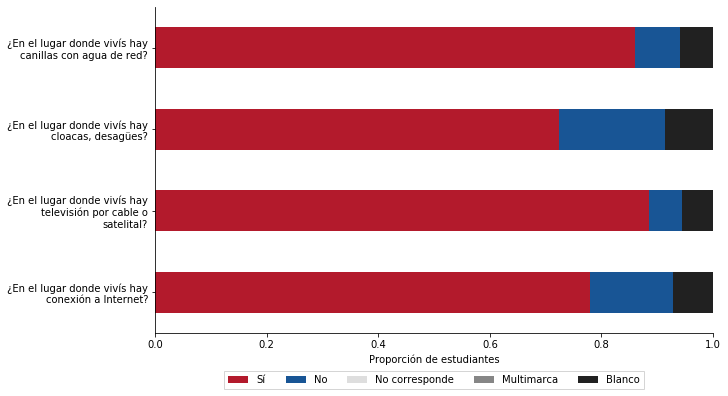

In [15]:
l = from_to('ap7a', 'ap7d')
l = l[::-1]
t=tabla_pond(l)
fig, ax = plt.subplots(figsize=(10,6))
barras_apiladas(t, ax, parse_labels=False) 

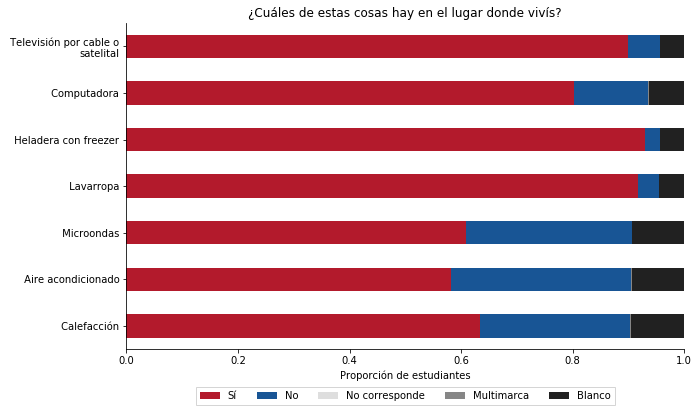

In [16]:
l = from_to('ap8a', 'ap8g')
l = l[::-1]
t=tabla_pond(l)
fig, ax = plt.subplots(figsize=(10,6))
barras_apiladas(t, ax)

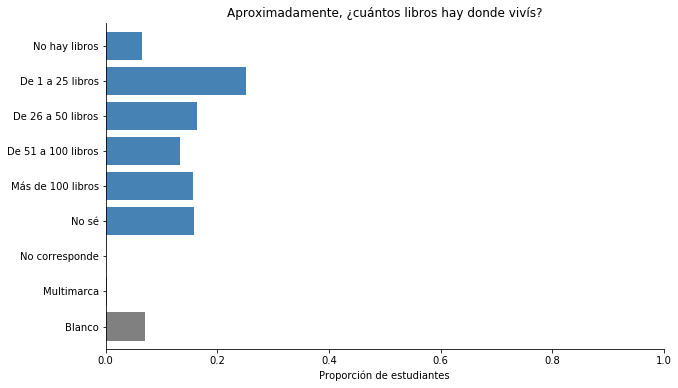

In [17]:
t = tabla_pond(['ap9'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

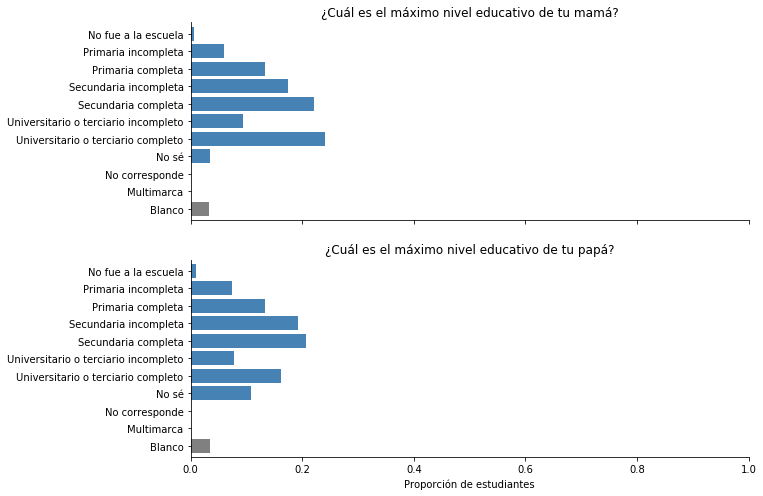

In [18]:
l = from_to('ap10', 'ap11')

fig, axs = plt.subplots(len(l),1, sharex=True, figsize=(10,8))

for i in range(len(l)):
    barras(tabla_pond([l[i]]), axs[i])

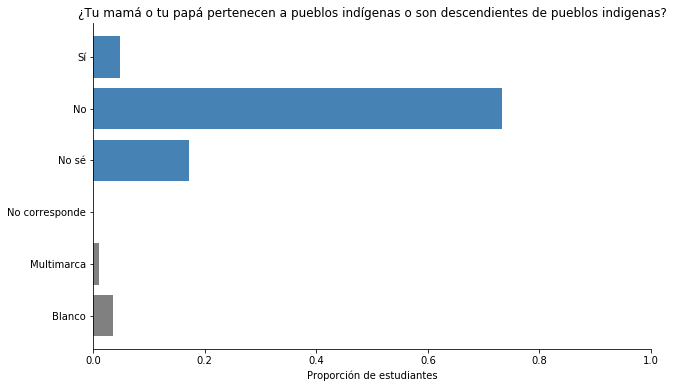

In [19]:
t = tabla_pond(['ap12'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

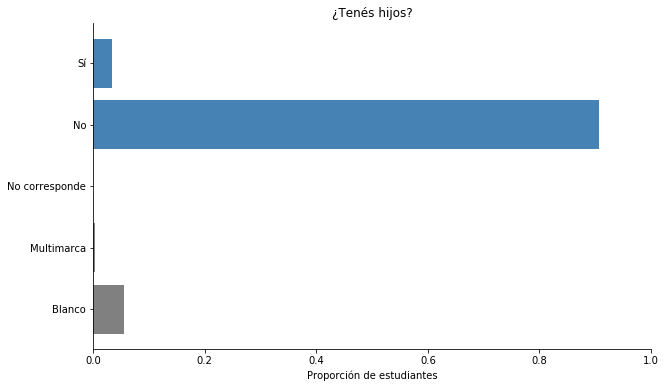

In [20]:
t = tabla_pond(['ap13'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

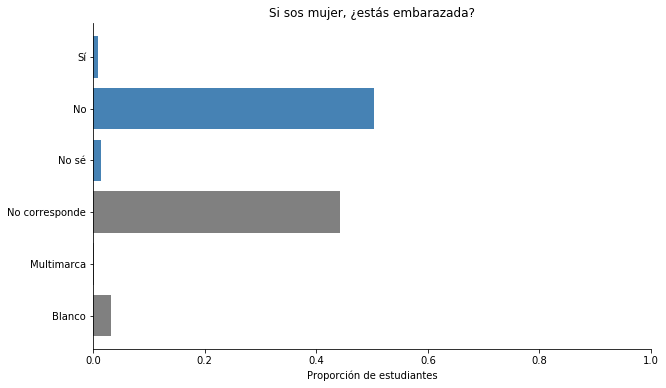

In [21]:
t = tabla_pond(['ap14'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

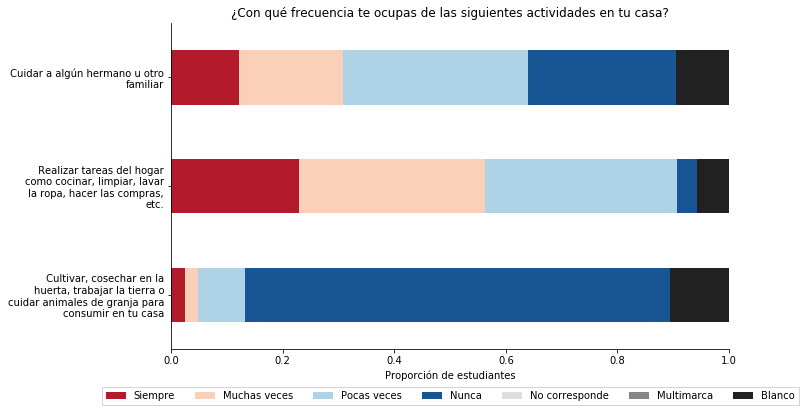

In [22]:
l = from_to('ap15a', 'ap15c')
l = l[::-1]
t=tabla_pond(l)
fig, ax = plt.subplots(figsize=(10,6))
barras_apiladas(t, ax)

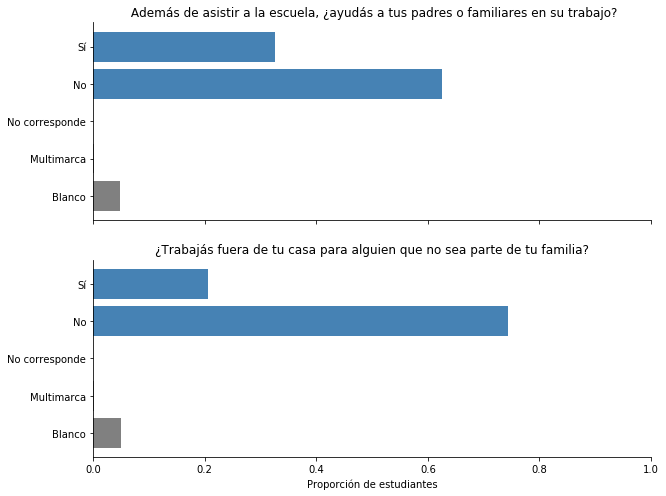

In [23]:
l = from_to('ap16', 'ap17')

fig, axs = plt.subplots(len(l),1, sharex=True, figsize=(10,8))

for i in range(len(l)):
    barras(tabla_pond([l[i]]), axs[i])

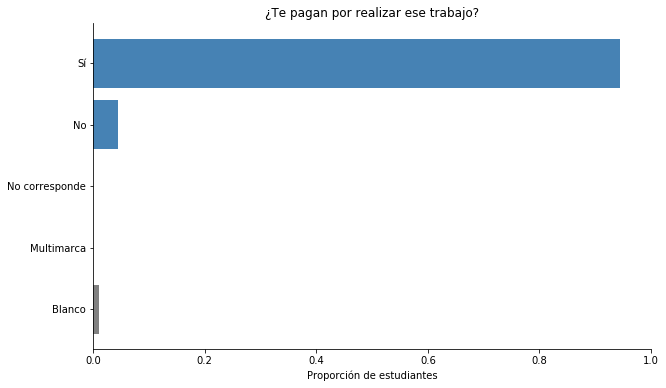

In [24]:
## De los que trabajan afuera de la casa?, les pagan?
t = tabla_pond(['ap18'], df=df[df['ap17'] == '1'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

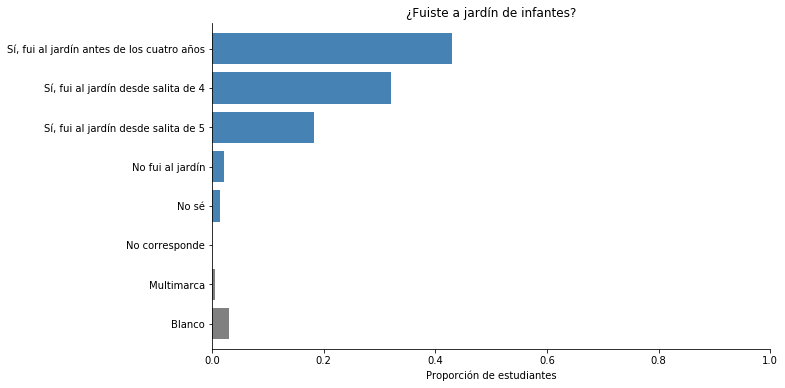

In [25]:
t = tabla_pond(['ap19'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

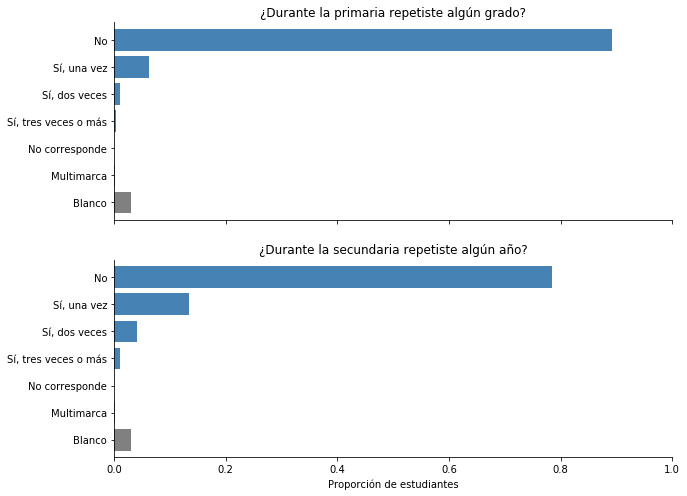

In [26]:
l = from_to('ap20', 'ap21')

fig, axs = plt.subplots(len(l),1, sharex=True, figsize=(10,8))

for i in range(len(l)):
    barras(tabla_pond([l[i]]), axs[i])

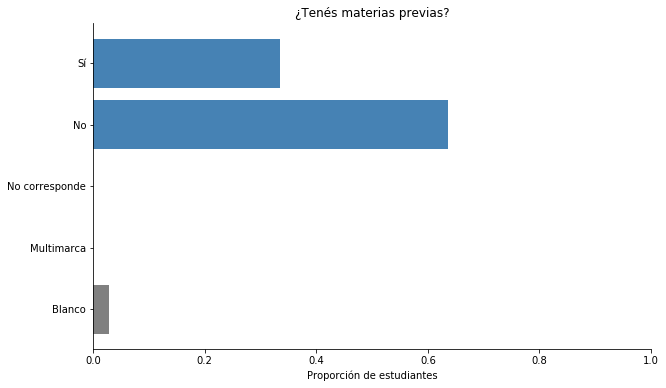

In [27]:
t = tabla_pond(['ap22'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

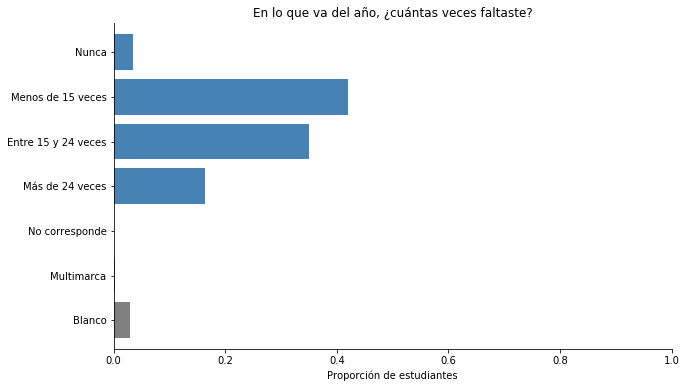

In [28]:
t = tabla_pond(['ap23'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

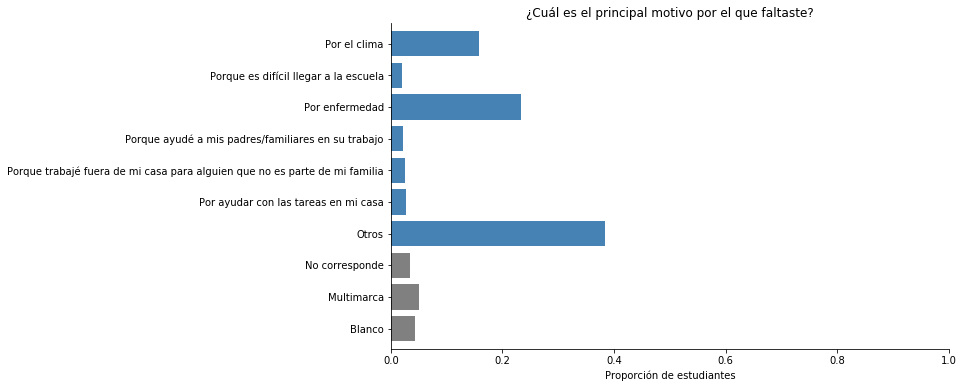

In [29]:
t = tabla_pond(['ap24'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

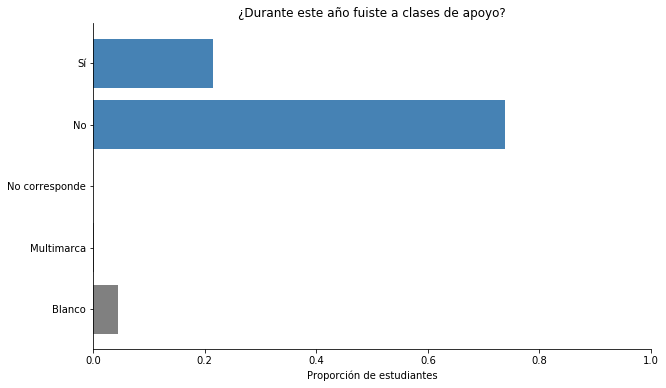

In [30]:
t = tabla_pond(['ap25'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

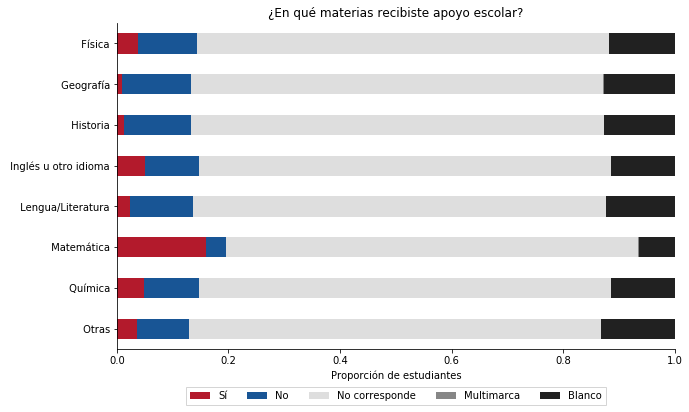

In [31]:
l = from_to('ap26a', 'ap26h')
l = l[::-1]
t=tabla_pond(l)
fig, ax = plt.subplots(figsize=(10,6))
barras_apiladas(t, ax)

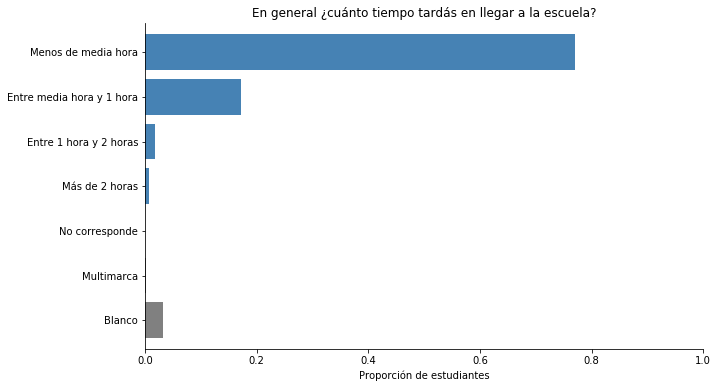

In [32]:
t = tabla_pond(['ap27'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

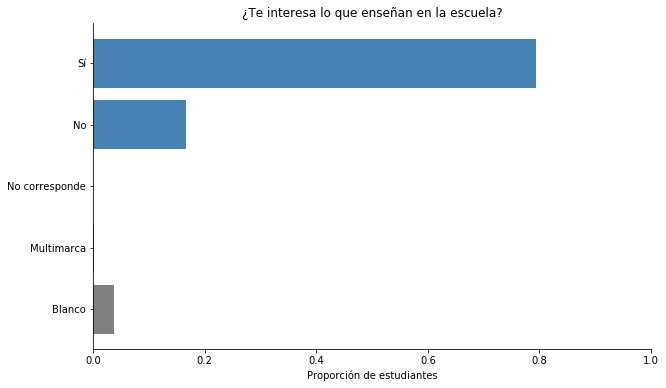

In [33]:
t = tabla_pond(['ap28'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

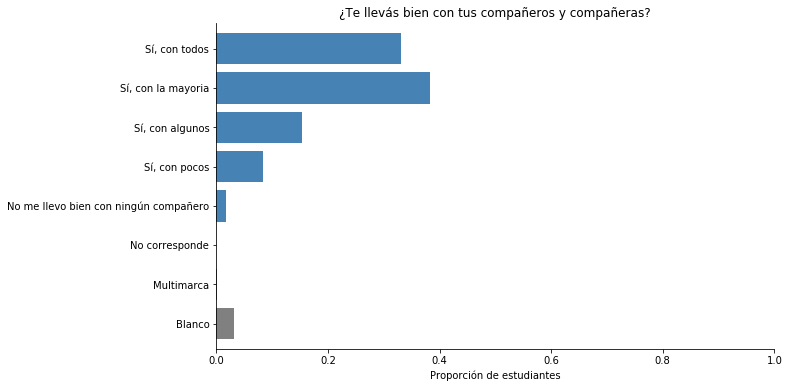

In [34]:
t = tabla_pond(['ap29'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

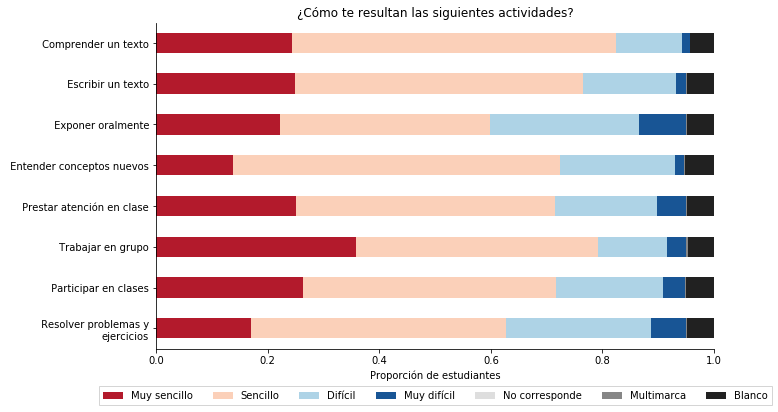

In [35]:
l = from_to('ap30a', 'ap30h')
l = l[::-1]
t=tabla_pond(l)
fig, ax = plt.subplots(figsize=(10,6))
barras_apiladas(t, ax)

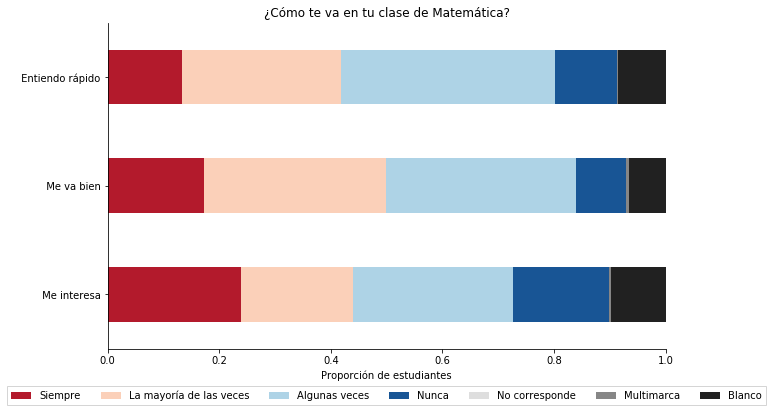

In [36]:
l = from_to('ap31a', 'ap31c')
l = l[::-1]
t=tabla_pond(l)
fig, ax = plt.subplots(figsize=(10,6))
barras_apiladas(t, ax)

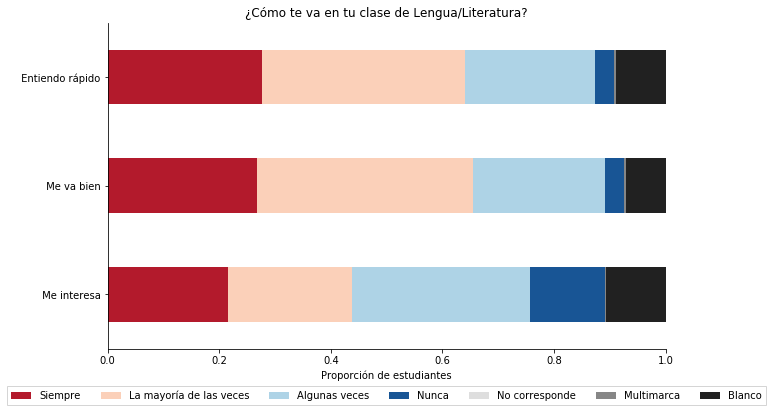

In [37]:
l = from_to('ap32a', 'ap32c')
l = l[::-1]
t=tabla_pond(l)
fig, ax = plt.subplots(figsize=(10,6))
barras_apiladas(t, ax)

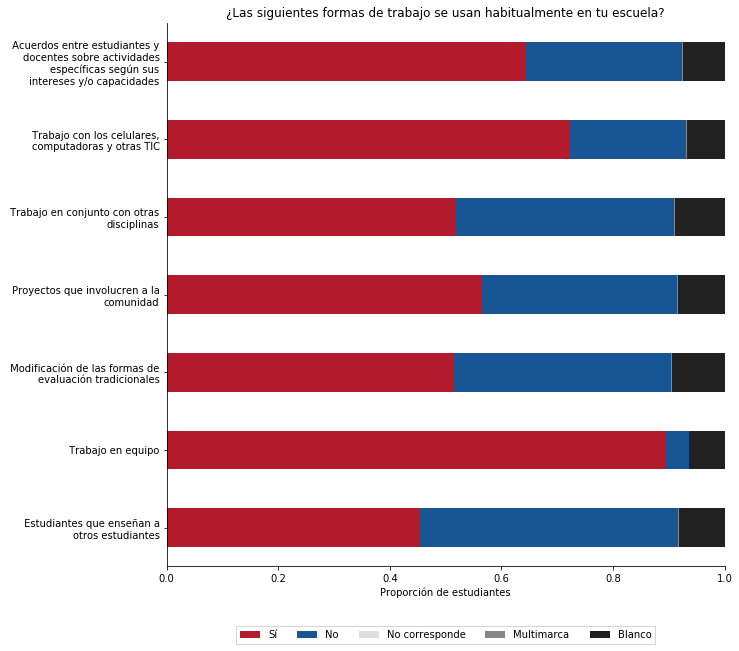

In [38]:
l = from_to('ap33a', 'ap33g')
l = l[::-1]
t=tabla_pond(l)
fig, ax = plt.subplots(figsize=(10,10))
barras_apiladas(t, ax)

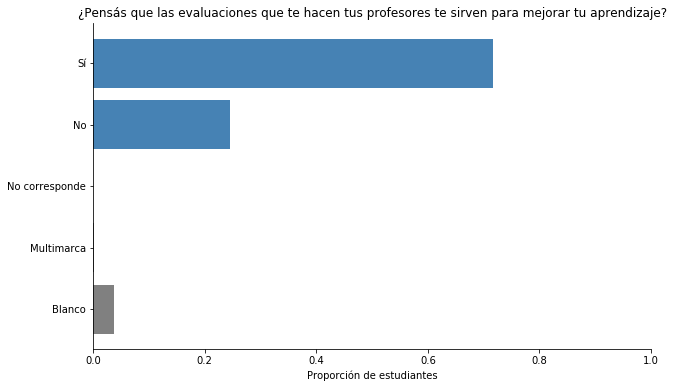

In [39]:
t = tabla_pond(['ap34a'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

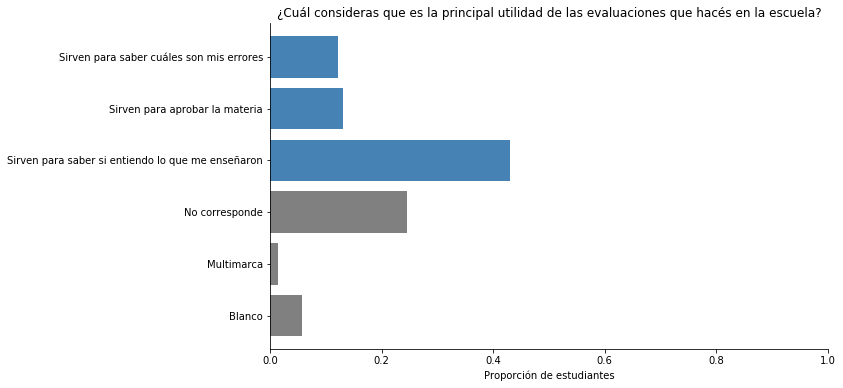

In [40]:
t = tabla_pond(['ap34b'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

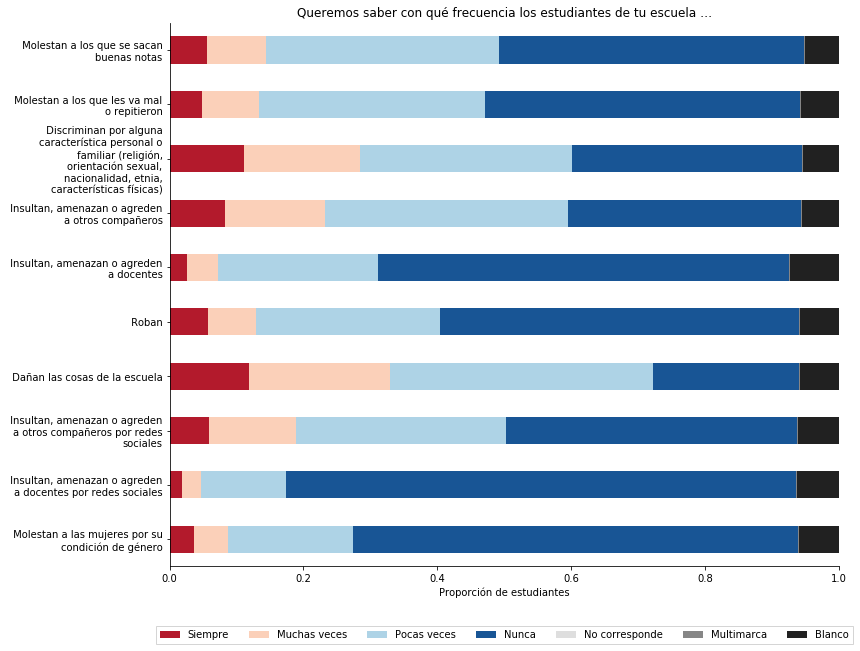

In [41]:
l = from_to('ap35a', 'ap35j')
l = l[::-1]
t=tabla_pond(l)
fig, ax = plt.subplots(figsize=(12,10))
barras_apiladas(t, ax)

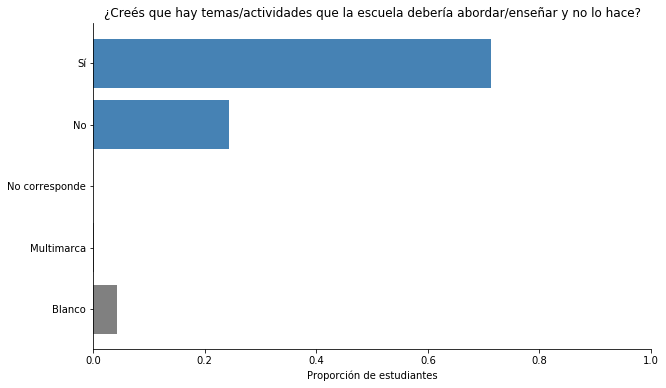

In [42]:
t = tabla_pond(['ap36'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

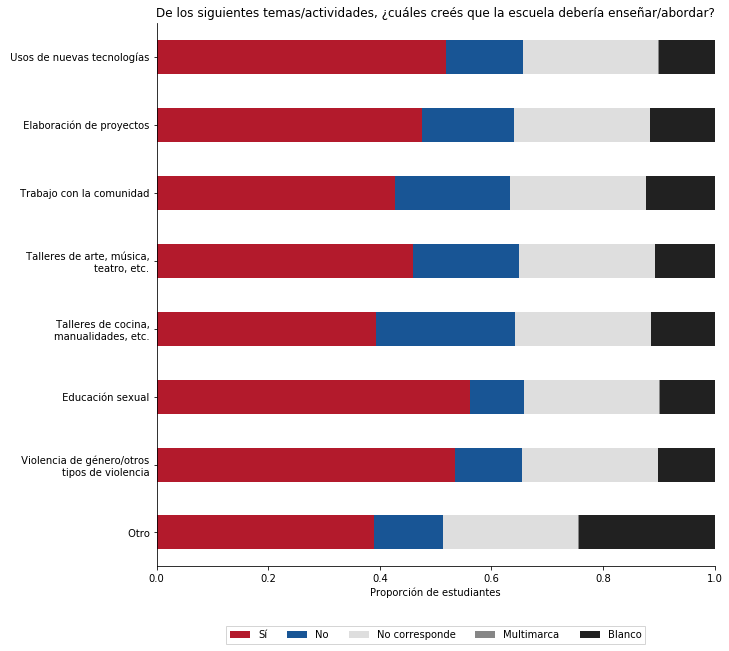

In [43]:
l = from_to('ap37a', 'ap37h')
l = l[::-1]
t=tabla_pond(l)
fig, ax = plt.subplots(figsize=(10,10))
barras_apiladas(t, ax)

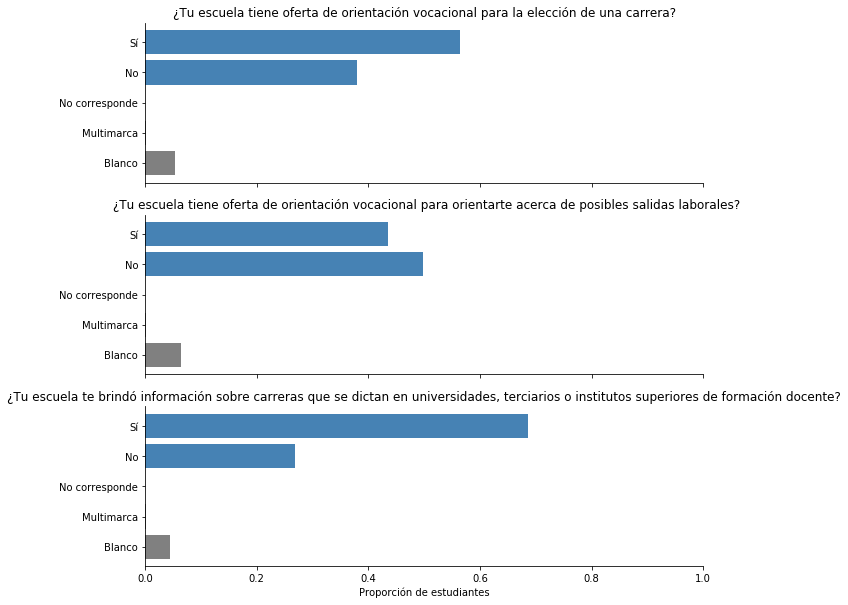

In [44]:
l = from_to('ap38', 'ap40')

fig, axs = plt.subplots(len(l),1, sharex=True, figsize=(10,10))

for i in range(len(l)):
    barras(tabla_pond([l[i]]), axs[i])

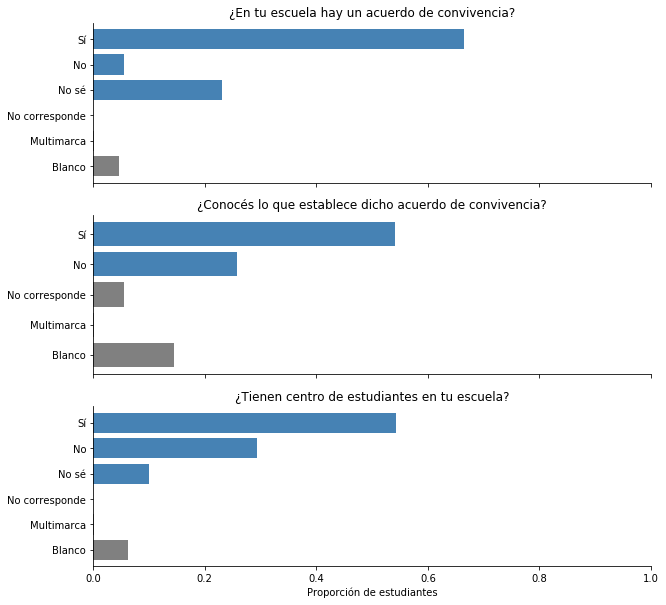

In [45]:
l = from_to('ap41', 'ap43')

fig, axs = plt.subplots(len(l),1, sharex=True, figsize=(10,10))

for i in range(len(l)):
    barras(tabla_pond([l[i]]), axs[i])

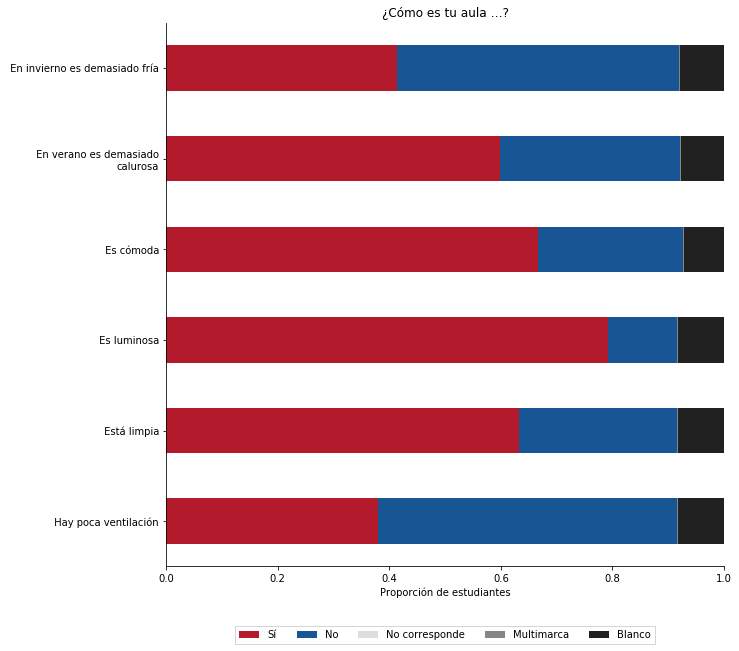

In [46]:
l = from_to('ap44a', 'ap44f')
l = l[::-1]
t=tabla_pond(l)
fig, ax = plt.subplots(figsize=(10,10))
barras_apiladas(t, ax)

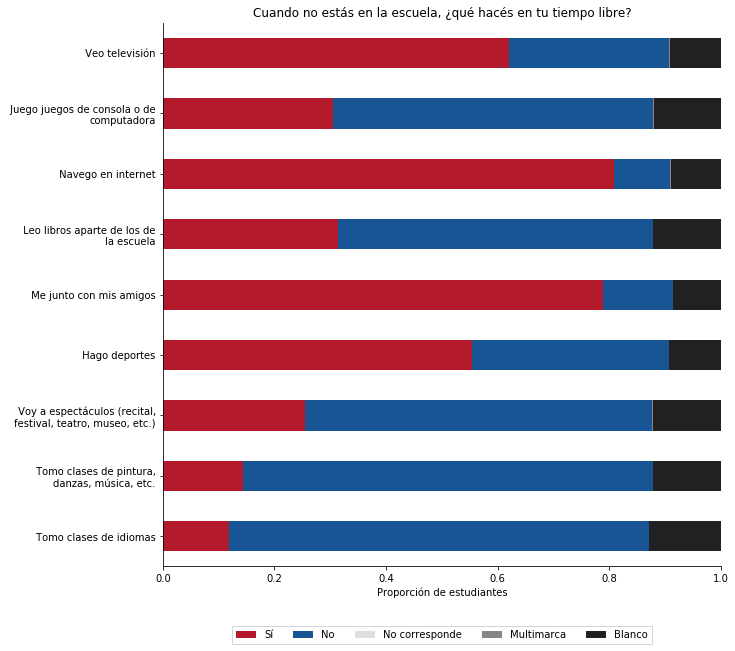

In [47]:
l = from_to('ap45a', 'ap45i')
l = l[::-1]
t=tabla_pond(l)
fig, ax = plt.subplots(figsize=(10,10))
barras_apiladas(t, ax)

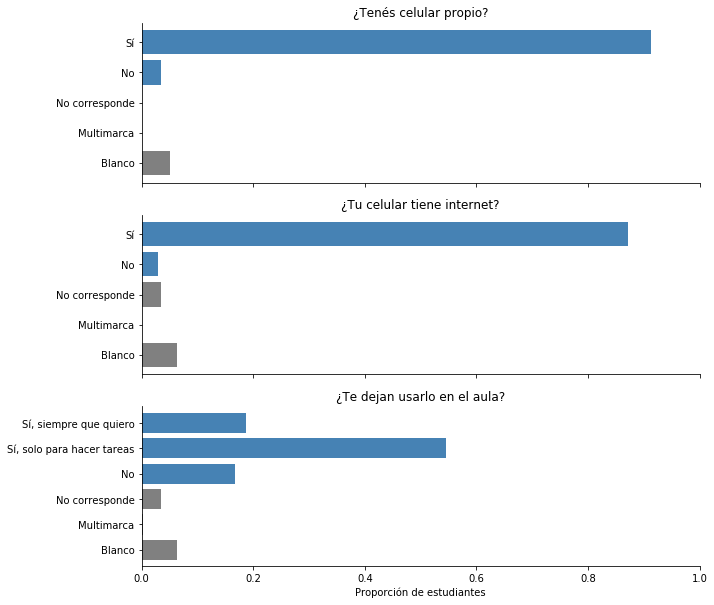

In [48]:
l = from_to('ap46a', 'ap46c')

fig, axs = plt.subplots(len(l),1, sharex=True, figsize=(10,10))

for i in range(len(l)):
    barras(tabla_pond([l[i]]), axs[i])

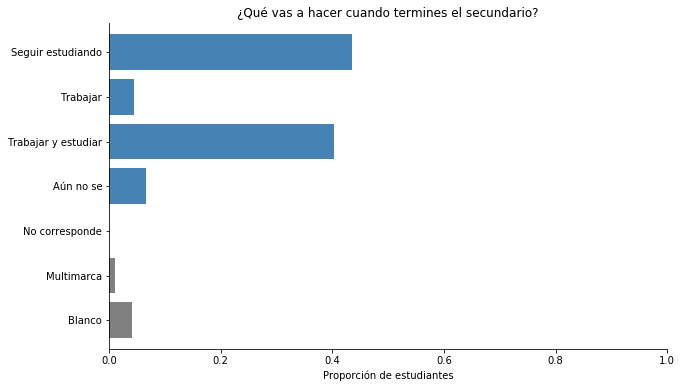

In [49]:
t = tabla_pond(['ap47'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

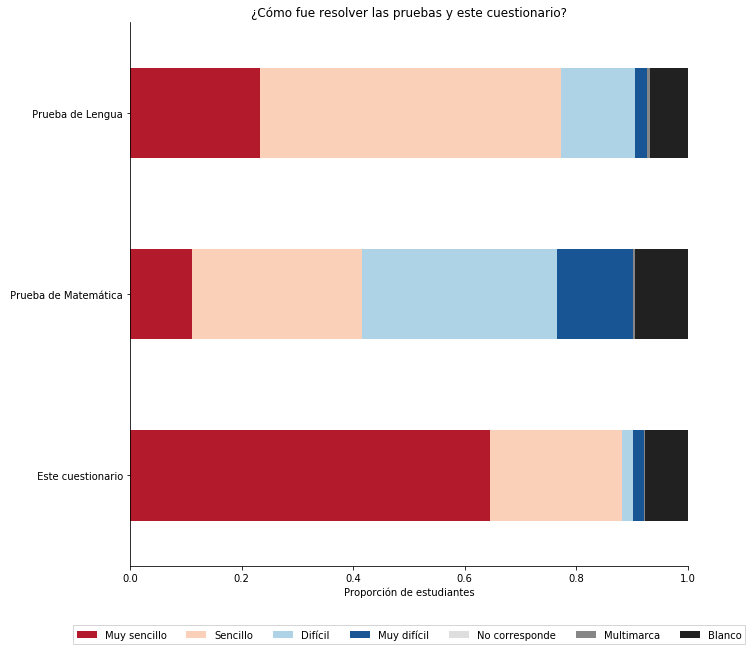

In [50]:
l = from_to('ap48a', 'ap48c')
l = l[::-1]
t=tabla_pond(l)
fig, ax = plt.subplots(figsize=(10,10))
barras_apiladas(t, ax)

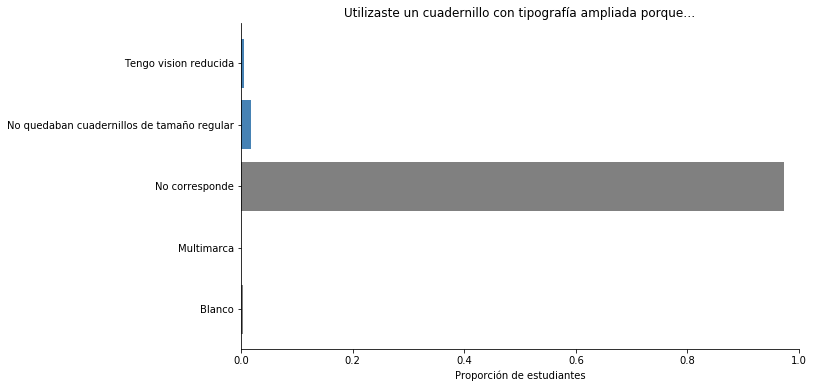

In [51]:
t = tabla_pond(['ap49'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

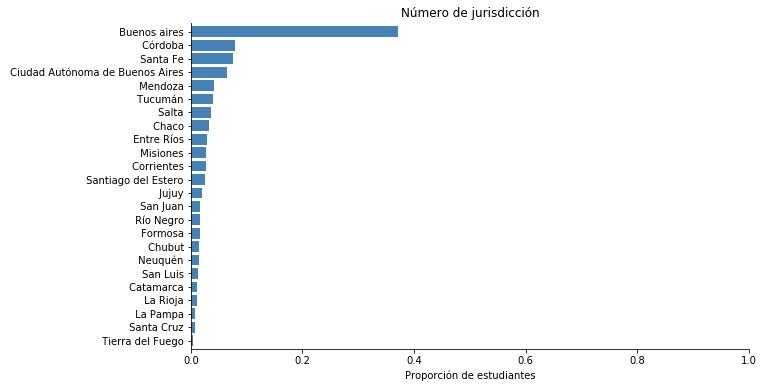

In [52]:
from pandas.api.types import CategoricalDtype
t = tabla_pond(['cod_provincia'])

c = CategoricalDtype(t.iloc[:,0].sort_values(ascending=False).index.values.tolist(), ordered=True)
t.index = t.index.astype(c)

t.iloc[:,0].sort_values(ascending=False).index
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

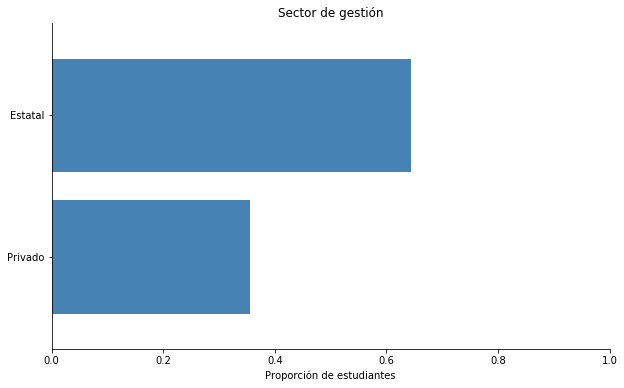

In [53]:
t = tabla_pond(['sector'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 

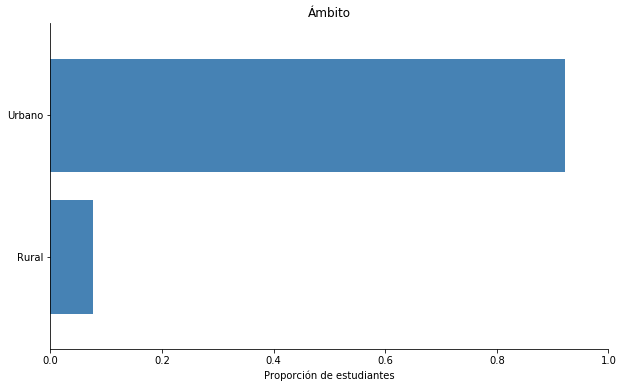

In [54]:
t = tabla_pond(['ambito'])
fig, ax = plt.subplots(figsize=(10,6))
barras(t, ax) 